In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from abc import ABC, abstractmethod
from typing import List, Set, Tuple

In [3]:
class Image:

    def __init__(
        self,
        image: np.array,
        bnd_boxes: List[Set[float]]
    ) -> None:

        self.image = image
        self.bnd_boxes = bnd_boxes

    def get_car(
        self,
        bnd_box
    ) -> np.array:
    # return cropped bounding box
    # allows to crop rotated bnd boxes

        img = self.image
        cnt = np.array([
                [[bnd_box[4], bnd_box[5]]],
                [[bnd_box[0], bnd_box[1]]],
                [[bnd_box[2], bnd_box[3]]],
                [[bnd_box[6], bnd_box[7]]]
            ])

        # rect = cv2.minAreaRect(cnt)
        # box = cv2.boxPoints(rect)
        # box = np.int0(box)
        # width = int(rect[1][0])
        # height = int(rect[1][1])
    
        points = np.array(cnt, np.int32)
        rect = cv2.boundingRect(points)
        x,y,w,h = rect
        
        # src_pts = box.astype("float32")
        # dst_pts = np.array([
        #                     [0, height-1],
        #                     [0, 0],
        #                     [width-1, 0],
        #                     [width-1, height-1]], dtype="float32")
        # 
        # M = cv2.getPerspectiveTransform(src_pts, dst_pts)
        # 
        # warped = cv2.warpPerspective(img, M, (height, width))
        new_img = img[y:y+h,x:x+w]
        return new_img

In [4]:
class ImageLoader(ABC):

    def __init__(self):
        pass

    def load_image(
        self,
        image_dir: str,
        annotation_dir: str
    ) -> None:

        image: np.array = cv2.imread(image_dir)
        with open(annotation_dir, 'r') as f:
            annotation_file: str = f.read()
            bnd_boxes = self.read_bnd_boxes(annotation_file, image)
        
        return Image(image, bnd_boxes)

    @abstractmethod
    def read_bnd_boxes(
        self,
        annotation_file: str,
        image: np.array
    ) -> List[Set[float]]:
        # returns list of sets with bnd boxes coords
        # (top_left_x, top_left_y, top_right_x, top_right_y
        # bottom_left_x, bottom_left_y, bottom_right_x, bottom_right_y)
        pass



In [5]:
class VehiculesImageLoader(ImageLoader):
    def read_bnd_boxes(
        self,
        annotation_file: str,
        image: np.array
    ) -> List[Set[float]]:

        annotations = []

        for ann_row in annotation_file.split('\n'):
            if len(ann_row) > 0:
                ann_row = ann_row.split(' ')
                
                # rotation = ann_row[2]
                # vehicle_class = ann_row[3]
                # is_whole = ann_row[4]
                # is_occluded = ann_row[5]
                # 
                # x_center = float(ann_row[0])
                # y_center = float(ann_row[1])
                
                x_1, y_1 = int(ann_row[6]), int(ann_row[6+4])
                x_2, y_2 = int(ann_row[7]), int(ann_row[7+4])
                x_3, y_3 = int(ann_row[8]), int(ann_row[8+4])
                x_4, y_4 = int(ann_row[9]), int(ann_row[9+4])
                
                polygon = [[x_1, y_1],[x_2, y_2], [x_3, y_3], [x_4, y_4]]
                
                result = [val for sublist in polygon for val in sublist]
                annotations.append(tuple(result))

                # points = np.array(polygon, np.int32)
                # 
                # top_left_x, top_left_y, height, width = cv2.boundingRect(points)
                # 
                # top_right_x = top_left_x + width
                # top_right_y = top_left_y
                # 
                # bottom_left_x = top_left_x
                # bottom_left_y = top_left_y + height
                # 
                # bottom_right_x = top_left_x + width
                # bottom_right_y = top_left_y + height
                # 
                # annotations.append((
                #     top_left_x, top_left_y,
                #     top_right_x, top_right_y,
                #     bottom_left_x, bottom_left_y,
                #     bottom_right_x, bottom_right_y))


        return annotations

In [6]:
    
class VehiculesFixedImageLoader(ImageLoader):
    
    def __init__(
        self,
        bnd_box_size: Tuple[int, int]
    ):
        super().__init__()
        self.bnd_box_size = bnd_box_size
    
    def read_bnd_boxes(
        self,
        annotation_file: str,
        image: np.array
    ) -> List[Set[float]]:

        annotations = []

        for ann_row in annotation_file.split('\n'):
            if len(ann_row) > 0:
                ann_row = ann_row.split(' ')
                
                # rotation = ann_row[2]
                # vehicle_class = ann_row[3]
                # is_whole = ann_row[4]
                # is_occluded = ann_row[5]
                
                xc = int(float(ann_row[0]))
                yc = int(float(ann_row[1]))
                
                w = self.bnd_box_size[0]
                h = self.bnd_box_size[1]

                top_left_x = xc - int(w/2)
                top_left_y = yc + int(h/2)

                top_right_x = xc + int(w/2)
                top_right_y = yc + int(h/2)

                bottom_left_x = xc - int(w/2)
                bottom_left_y = yc - int(h/2)

                bottom_right_x = xc + int(w/2)
                bottom_right_y = yc - int(h/2)

                annotations.append((
                    top_left_x, top_left_y,
                    top_right_x, top_right_y,
                    bottom_left_x, bottom_left_y,
                    bottom_right_x, bottom_right_y))


        return annotations

In [7]:
vehiculesImageLoader = VehiculesImageLoader()

image = vehiculesImageLoader.load_image(
    '../../data/raw/vehicules/Vehicules1024/00000006_co.png',
    '../../data/raw/vehicules/Annotations1024/00000006.txt'
)

In [8]:
for bnd in image.bnd_boxes:
    print(bnd)

(31, 720, 38, 730, 10, 745, 3, 734)
(10, 278, 22, 285, 9, 312, 1, 306)
(22, 314, 34, 316, 30, 353, 12, 349)
(78, 334, 106, 356, 99, 366, 70, 343)
(76, 174, 106, 170, 109, 183, 77, 187)
(121, 163, 141, 166, 135, 201, 111, 198)
(141, 167, 156, 167, 164, 207, 151, 209)


In [105]:
BND_BOX_SIZE = (100, 100)

vehiculesFixedImageLoader = VehiculesFixedImageLoader(bnd_box_size=BND_BOX_SIZE)

image = vehiculesFixedImageLoader.load_image(
    '../../data/raw/vehicules/Vehicules1024/00000001_co.png',
    '../../data/raw/vehicules/Annotations1024/00000001.txt'
)

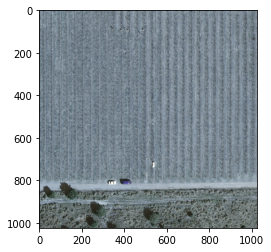

In [101]:
# plt.figure(figsize=(30,30))
plt.imshow(image.image)
plt.show()


In [106]:
bnd_box = image.bnd_boxes[0]
bnd_box

(294, 862, 394, 862, 294, 762, 394, 762)

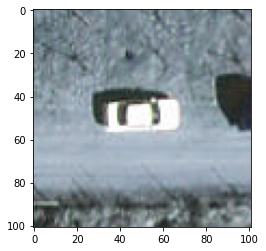

In [108]:
plt.imshow(image.get_car(image.bnd_boxes[0]))